<a href="https://colab.research.google.com/github/Rodzxc/Deteccion_de_fraudes/blob/main/fraud_detection_(4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Librerias

In [ ]:
pip install benfordslaw

In [ ]:
pip install lazypredict

In [ ]:
import pandas as pd
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import seaborn as sns

from benfordslaw import benfordslaw

from scipy.stats import yeojohnson

from lazypredict.Supervised import LazyClassifier

from xgboost import XGBClassifier

from imblearn.under_sampling import RandomUnderSampler

#from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

#from imblearn.under_sampling import NearMiss

## 2. Dataset

In [ ]:
df = pd.read_parquet('/content/dataset_fraud_detection.parquet')

In [ ]:
df.head(4)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0


# <font color="magenta">*Análisis de datos*</font>

Conclusiones:<br>
- no hay datos nulos.
- los datos fraudulentos son el 0.13% del total.
- los datos fraudulento son constantes a lo largo del tiempo.
- los datos fraudulentos pertenecen a la categorias "CASH_OUT" Y "TRANSFER".
- los histogramas de datos auténticos y frauduletos tienen cola derecha.
- las correlaciones de los datos auténticos es diferente a la de los datos frauduletos.

In [ ]:
df.shape

(6362620, 11)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
step,6362620.00,243.40,142.33,1.00,156.00,239.00,335.00,743.00
amount,6362620.00,179861.90,603858.23,0.00,13389.57,74871.94,208721.48,92445516.64
oldbalanceOrg,6362620.00,833883.10,2888242.67,0.00,0.00,14208.00,107315.18,59585040.37
newbalanceOrig,6362620.00,855113.67,2924048.50,0.00,0.00,0.00,144258.41,49585040.37
oldbalanceDest,6362620.00,1100701.67,3399180.11,0.00,0.00,132705.66,943036.71,356015889.35
newbalanceDest,6362620.00,1224996.40,3674128.94,0.00,0.00,214661.44,1111909.25,356179278.92
isFraud,6362620.00,0.00,0.04,0.00,0.00,0.00,0.00,1.00
isFlaggedFraud,6362620.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00


In [ ]:
df.isnull().values.any()

False

### 2.1. Cantidad de registros 'fraudes'

In [ ]:
print('is Fraud?')
for i, j in df['isFraud'].value_counts().items():
    print(i, j)

is Fraud?
0 6354407
1 8213


In [ ]:
fraudes = (df['isFraud'].value_counts()[1] / df['isFraud'].value_counts()[0])*100
print(f'El porcentaje de fraudes es de {fraudes.round(2)}%' )

El porcentaje de fraudes es de 0.13%


## 3. Análisis columna 'step'

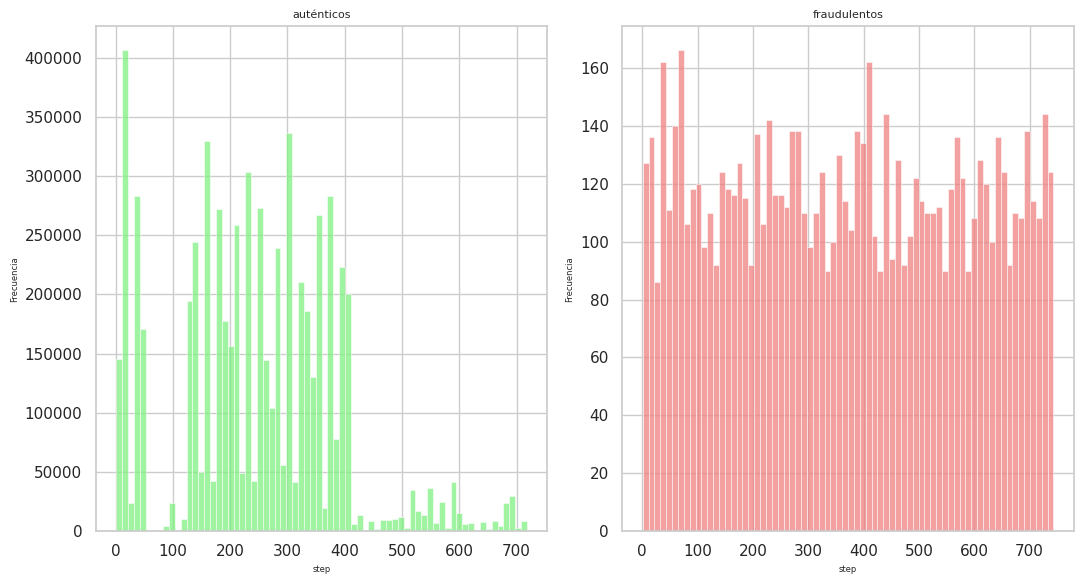

In [ ]:
# Histograma check/fraud , col = 'step'
# Crea subplots
fig, axs = plt.subplots(1, 2, figsize=(11, 6))

# Grilla
sns.set(style="whitegrid")


# Ajustes del histograma - datos auténticos
sns.histplot(df[df['isFraud']==0]['step'], bins=70, ax=axs[0], color='#80f080')
axs[0].set_title('auténticos', fontsize=8)
axs[0].set_xlabel('step', fontsize=6)
axs[0].set_ylabel('Frecuencia', fontsize=6)


# Ajustes del histograma - datos fraudulentos
sns.histplot(df[df['isFraud']==1]['step'], bins=70,  ax=axs[1], color='#f08080')
axs[1].set_title('fraudulentos', fontsize=8)
axs[1].set_xlabel('step', fontsize=6)
axs[1].set_ylabel('Frecuencia', fontsize=6)

# Ajusta el espaciado entre subplots
plt.tight_layout()
plt.show()

## 4. Columna 'type'
A partir de la columna *type*, se detecta que todos los registros fraudulentos corresponden a las categorias "CASH_OUT" Y "TRANSFER".<br>
A continuación se procede a utilizar los registros con esas 2 categorias.<br>
Se dividen en datos auténticos y fraudulentos:
- **df_check**
- **df_fraud**

In [ ]:
print(df['type'].unique())

['PAYMENT' 'TRANSFER' 'CASH_OUT' 'DEBIT' 'CASH_IN']


In [ ]:
# Cantidad de registros frauduletos agrupados por 'type'
for i, j in df[df['isFraud'] == 1]['type'].value_counts().items():
    print(i, j)

CASH_OUT 4116
TRANSFER 4097


In [ ]:
# Lista de categorias, ['CASH_OUT' , 'TRANSFER']
type_fraud = df[df['isFraud'] == 1]['type'].unique()

# Registros con las categorias de la lista
df_filtered = df[df['type'].isin(type_fraud)]

# dataframes operaciones verdaderas y fraudulentas
df_check = df_filtered[df_filtered['isFraud'] == 0]
df_fraud = df_filtered[df_filtered['isFraud'] == 1]

print(df_check.shape)
print(df_fraud.shape)

(2762196, 11)
(8213, 11)


## 5. Columna 'amount'
A continuación se realiza un análisis de la distribución de la columna *amount*.<br>
Esto se realiza con los dataframes df_check y df_fraud.<br>
Se concluye que:
- Los datos tienen una distribución asimértrica hacia la derecha.
- Tiene diferentes medidas de tendencias centrales, difieren en la moda, media, mediana, cuartiles, etc.

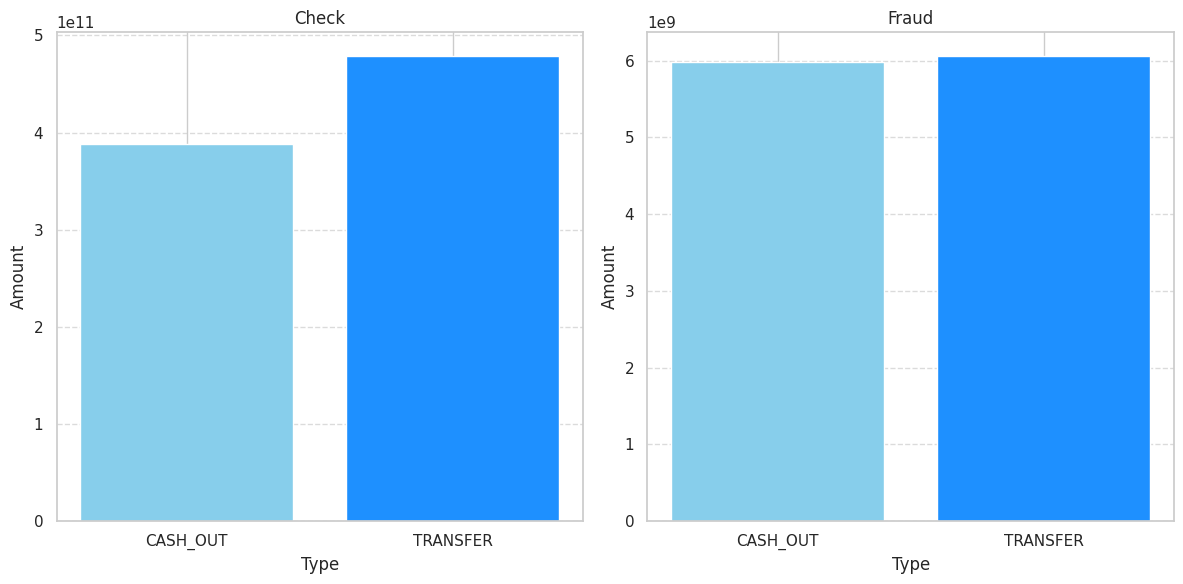

In [ ]:
# Gráfica de barras check/fraud
# Crea subplots para dos pares de barras
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
colors = ['skyblue', 'dodgerblue']

# Gráfico de barras para check
axs[0].bar([0, 1], df_check.groupby('type')['amount'].sum(), color=colors, tick_label=['CASH_OUT', 'TRANSFER'])
axs[0].set_xlabel('Type')
axs[0].set_ylabel('Amount')
axs[0].set_title('Check')
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

# Gráfico de barras para fraud
axs[1].bar([0, 1], df_fraud.groupby('type')['amount'].sum(), color=colors, tick_label=['CASH_OUT', 'TRANSFER'])
axs[1].set_xlabel('Type')
axs[1].set_ylabel('Amount')
axs[1].set_title('Fraud')
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

# Ajusta el espaciado entre subplots
plt.tight_layout()
plt.show()

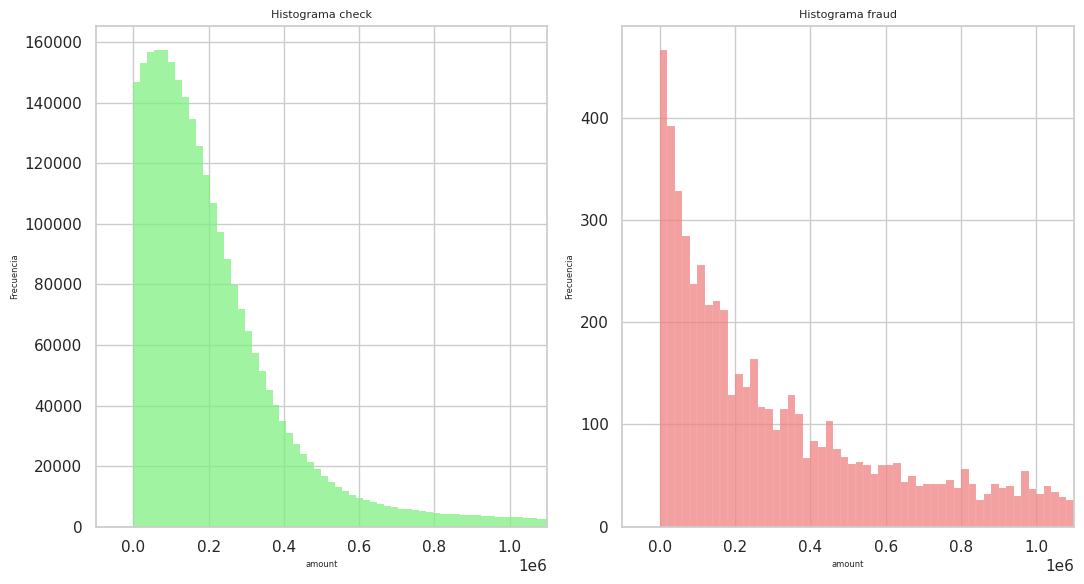

In [ ]:
# Histograma check/fraud , col = 'amount'
# Crea subplots
fig, axs = plt.subplots(1, 2, figsize=(11, 6))

# Grilla
sns.set(style="whitegrid")


# Ajustes del histograma - check
sns.histplot(df_check['amount'], bins=5000, ax=axs[0], color='#80f080')
axs[0].set_title('Histograma check', fontsize=8)
axs[0].set_xlabel('amount', fontsize=6)
axs[0].set_ylabel('Frecuencia', fontsize=6)
axs[0].set_xlim(-0.1e6,1.1e6)

# Ajustes del histograma - fraud
sns.histplot(df_fraud['amount'], bins=500, ax=axs[1], color='#f08080')
axs[1].set_title('Histograma fraud', fontsize=8)
axs[1].set_xlabel('amount', fontsize=6)
axs[1].set_ylabel('Frecuencia', fontsize=6)
axs[1].set_xlim(-0.1e6,1.1e6)

# Ajusta el espaciado entre subplots
plt.tight_layout()
plt.show()

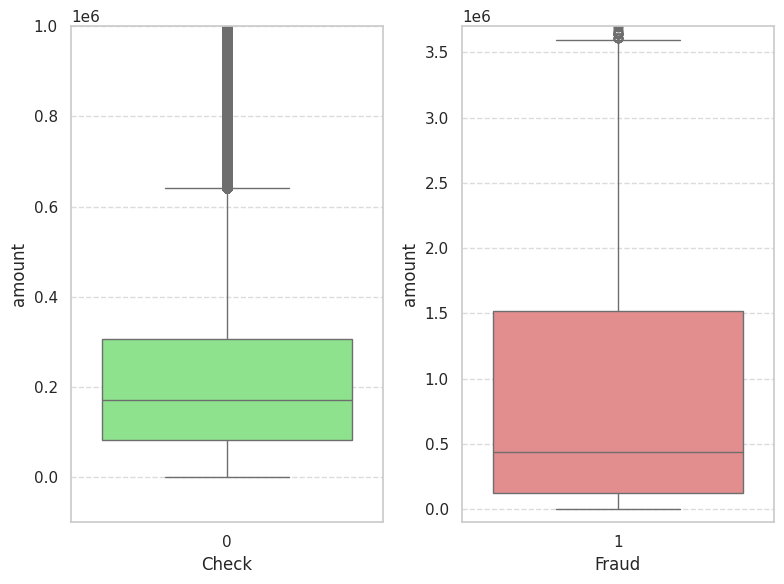

In [ ]:
# Gráfica boxplot check/fraud
# Crea subplots
fig, axs = plt.subplots(1, 2, figsize=(8, 6))

# Gráfico boxplot para check
sns.boxplot(x='isFraud', y='amount', data=df_check, ax=axs[0], color='#80f080')
axs[0].set_xlabel('Check')
axs[0].grid(axis='y', linestyle='--', alpha=0.7)
axs[0].set_ylim(-0.1e6, 1e6)

# Gráfico boxplot para fraud
sns.boxplot(x='isFraud', y='amount', data=df_fraud, ax=axs[1], color='#f08080')
axs[1].set_xlabel('Fraud')
axs[1].grid(axis='y', linestyle='--', alpha=0.7)
axs[1].set_ylim(-0.1e6, 3.7e6)

# Ajusta el espaciado entre subplots
plt.tight_layout()
plt.show()

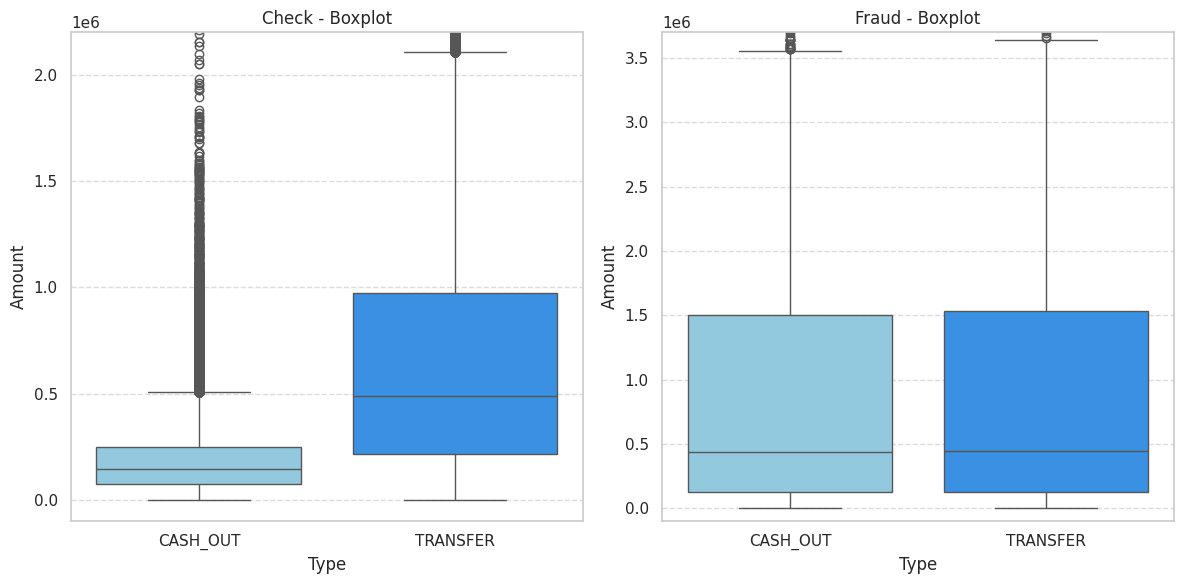

In [ ]:
# Gráfica boxplot check/fraud y type
# Crea subplots para dos pares de boxplot
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
colors = ['skyblue', 'dodgerblue']

# Gráfico boxplot para check
sns.boxplot(x='type', y='amount', data=df_check, ax=axs[0], palette=colors, order=['CASH_OUT', 'TRANSFER'] )
axs[0].set_xlabel('Type')
axs[0].set_ylabel('Amount')
axs[0].set_title('Check - Boxplot')
axs[0].grid(axis='y', linestyle='--', alpha=0.7)
axs[0].set_ylim(-0.1e6, 2.2e6)

# Gráfico boxplot para fraud
sns.boxplot(x='type', y='amount', data=df_fraud, ax=axs[1], palette=colors, order=['CASH_OUT', 'TRANSFER'])
axs[1].set_xlabel('Type')
axs[1].set_ylabel('Amount')
axs[1].set_title('Fraud - Boxplot')
axs[1].grid(axis='y', linestyle='--', alpha=0.7)
axs[1].set_ylim(-0.1e6, 3.7e6)

# Ajusta el espaciado entre subplots
plt.tight_layout()
plt.show()

## 6. Correlación

### 6.1. Columna *type*, transformación one_hot_encoding

In [ ]:
# Eliminación columnas isFraud y isFlaggendFraud; y transformación one_hot_encoding
df2 = pd.concat([df.drop(['isFraud','isFlaggedFraud'], axis=1),pd.get_dummies(df.type)], axis=1)

# Eliminación de las columnas type, nameOrig y nameDest
df2 = df2.drop(['type', 'nameOrig', 'nameDest'], axis=1)

# Se agregan las columnas isFraud y isFlaggedFraud al final
df2 = pd.concat([df2,df.iloc[:,-2:]], axis=1)
pd.DataFrame.head(df2)
df2.head(4)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,isFraud,isFlaggedFraud
0,1,9839.64,170136.00,160296.36,0.00,0.00,0,0,0,1,0,0,0
1,1,1864.28,21249.00,19384.72,0.00,0.00,0,0,0,1,0,0,0
2,1,181.00,181.00,0.00,0.00,0.00,0,0,0,0,1,1,0
3,1,181.00,181.00,0.00,21182.00,0.00,0,1,0,0,0,1,0


### 6.2. Correlación de los datos

In [ ]:
# Correlación
corr_df2 = df2.corr(method="kendall")

# Crear una máscara para el triángulo superior
mask = np.triu(np.ones_like(corr_df2, dtype=bool), k=0)

# Aplicar la máscara para eliminar el triángulo inferior
matrix_df2 = corr_df2.where(mask)

# Aplicar el estilo de fondo gradiente
matrix_df2 = matrix_df2.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)

# Cambiar el color de los valores NaN a negro
matrix_df2 = matrix_df2.applymap(lambda x: 'color: black' if pd.isna(x) else '')

matrix_df2

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,isFraud,isFlaggedFraud
step,1.000000,0.000425,-0.004271,-0.007891,-0.003191,-0.003811,0.002013,-0.009520,0.002385,0.004963,0.004232,0.017038,0.001737
amount,nan,1.000000,0.033269,-0.046212,0.435644,0.496851,0.191848,0.279373,-0.093276,-0.605642,0.292969,0.029443,0.002166
oldbalanceOrg,nan,nan,1.000000,0.708727,0.019672,-0.003352,0.451082,-0.230236,0.007218,-0.094640,-0.118071,0.033490,0.002092
newbalanceOrig,nan,nan,nan,1.000000,0.037041,-0.068711,0.671878,-0.425764,0.017301,-0.040614,-0.206365,-0.025128,0.002387
oldbalanceDest,nan,nan,nan,nan,1.000000,0.855518,0.249819,0.303612,0.040386,-0.642081,0.187932,-0.014856,-0.001424
newbalanceDest,nan,nan,nan,nan,nan,1.000000,0.124130,0.401976,0.031936,-0.674860,0.264745,-0.004450,-0.001497
CASH_IN,nan,nan,nan,nan,nan,nan,1.000000,-0.391047,-0.042987,-0.379522,-0.160535,-0.019089,-0.000842
CASH_OUT,nan,nan,nan,nan,nan,nan,nan,1.000000,-0.059625,-0.526422,-0.222672,0.011256,-0.001168
DEBIT,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,-0.057868,-0.024478,-0.002911,-0.000128
PAYMENT,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,-0.216110,-0.025697,-0.001133


### 6.3. Correlación de los datos fraudulentos

In [ ]:
# Selección de datos fraudulentos
corr_fraud = df2[df2['isFraud']==1]
corr_fraud = corr_fraud.drop(['CASH_IN' , 'DEBIT' , 'PAYMENT' , 'isFraud'] , axis=1)

# Correlación
corr_fraud = corr_fraud.corr(method="kendall")

# Crear una máscara para el triángulo superior
mask = np.triu(np.ones_like(corr_fraud, dtype=bool), k=0)

# Aplicar la máscara para eliminar el triángulo inferior
matrix = corr_fraud.where(mask)

# Aplicar el estilo de fondo gradiente
matrix = matrix.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)

# Cambiar el color de los valores NaN a negro
matrix = matrix.applymap(lambda x: 'color: black' if pd.isna(x) else '')

matrix

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_OUT,TRANSFER,isFlaggedFraud
step,1.000000,0.023804,0.028001,0.045337,-0.006337,0.003247,-0.002662,0.002662,0.028232
amount,nan,1.000000,0.994142,0.182592,-0.005334,0.171606,-0.006314,0.006314,0.040937
oldbalanceOrg,nan,nan,1.000000,0.189604,-0.007188,0.166980,-0.008969,0.008969,0.045648
newbalanceOrig,nan,nan,nan,1.000000,-0.088110,-0.112350,-0.138870,0.138870,0.311498
oldbalanceDest,nan,nan,nan,nan,1.000000,0.676614,0.645758,-0.645758,-0.028701
newbalanceDest,nan,nan,nan,nan,nan,1.000000,0.808061,-0.808061,-0.036167
CASH_OUT,nan,nan,nan,nan,nan,nan,1.000000,-1.000000,-0.044283
TRANSFER,nan,nan,nan,nan,nan,nan,nan,1.000000,0.044283
isFlaggedFraud,nan,nan,nan,nan,nan,nan,nan,nan,1.000000


### 6.4. Correlación de los datos auténticos

In [ ]:
# Selección de datos auténticos
corr_check = df2[df2['isFraud']==0]
corr_check = corr_check.drop(['isFraud' , 'isFlaggedFraud'] , axis=1)

# Correlación
corr_check = corr_check.corr(method="kendall")

# Crear una máscara para el triángulo superior
mask = np.triu(np.ones_like(corr_check, dtype=bool), k=0)

# Aplicar la máscara para eliminar el triángulo inferior
matrix = corr_check.where(mask)

# Aplicar el estilo de fondo gradiente
matrix = matrix.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)

# Cambiar el color de los valores NaN a negro
matrix = matrix.applymap(lambda x: 'color: black' if pd.isna(x) else '')

matrix

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
step,1.000000,-0.000118,-0.004887,-0.007497,-0.002936,-0.003750,0.002340,-0.009724,0.002438,0.005409,0.003321
amount,nan,1.000000,0.031991,-0.045484,0.436817,0.497654,0.192706,0.279639,-0.093315,-0.605813,0.292653
oldbalanceOrg,nan,nan,1.000000,0.710583,0.019997,-0.003436,0.452009,-0.230933,0.007353,-0.093777,-0.120436
newbalanceOrig,nan,nan,nan,1.000000,0.036834,-0.068752,0.671859,-0.425870,0.017204,-0.041418,-0.205894
oldbalanceDest,nan,nan,nan,nan,1.000000,0.855854,0.249678,0.303472,0.040351,-0.642938,0.190644
newbalanceDest,nan,nan,nan,nan,nan,1.000000,0.124139,0.401497,0.031940,-0.675636,0.268021
CASH_IN,nan,nan,nan,nan,nan,nan,1.000000,-0.391205,-0.043050,-0.380208,-0.160105
CASH_OUT,nan,nan,nan,nan,nan,nan,nan,1.000000,-0.059639,-0.526713,-0.221799
DEBIT,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,-0.057962,-0.024408
PAYMENT,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,-0.215564


# <font color="magenta">*ML - Aprendizaje Supervizado*</font>
Conclusiones:<br>
- los mejores resultados se obtuvieron de la siguiente manera:
  - submuestreo.
  - ajuste a distribución normal y escalado RobustScaler y Standardscaler.
  - selección de características mediante RFECV y XGBClassifier como modelo y clasificador.

- se utiliza lazypredict como otra buena alternativa donde se pueden ver los diferentes modelos de predicción y sus métricas. XGBClassifier esta tercero demostrando ser uno de los mejores estimadores.   

## 7. Balanceo de clases

Como anteriormente se ha expuesto, la cantidad de datos fraudulentos es de 0.13% y por lo tanto, se necesitaria balancear los datos de tal modo que la cantidad de datos fraudulentos y auténticos sean iguales.

Para realizar este procedimiento, se realiza un submuestreo (undersamping) de los datos auténticos, disminuyendo su número hasta igualar la cantidad de datos fraudulentos, pero también evitando la pérdida de información.

In [ ]:
# Submuestreo de los datos auténticos
X = df2.drop('isFraud', axis=1)
y = df2['isFraud']

undersample = RandomUnderSampler()
X_under, y_under = undersample.fit_resample(X, y)

print(pd.Series(y_under).value_counts())

0    8213
1    8213
Name: isFraud, dtype: int64


In [ ]:
# Nombres de las columnas de df2
columns = df2.columns

# Selecciono todas las columnas excepto isFraud
columns_X = np.delete(columns, 11)
columns_X

Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER',
       'isFlaggedFraud'],
      dtype='object')

In [ ]:
# Selecciono isFraud
columns_y = columns[-2]
columns_y

'isFraud'

In [ ]:
# DataFrame df3, datos fraudulentos + submuestreo de los auténticos
X_df = pd.DataFrame(X_under, columns=columns_X)
y_df = pd.DataFrame(y_under, columns=[columns_y])

df3 = pd.concat([X_df, y_df], axis=1)

# Mezclar los datos para evitar sesgos debido al orden
df3 = shuffle(df3)
df3.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,isFlaggedFraud,isFraud
16296,732,249365.63,249365.63,0.00,0.00,0.00,0,0,0,0,1,0,1
11507,290,165368.59,165368.59,0.00,19946.26,185314.85,0,1,0,0,0,0,1
13010,425,10000000.00,49585040.37,39585040.37,0.00,0.00,0,0,0,0,1,0,1
8047,259,124437.98,30976.00,0.00,1695263.44,1819701.42,0,1,0,0,0,0,0
2563,355,254693.92,1475.00,0.00,168107.99,422801.91,0,1,0,0,0,0,0


## 8. Análisis de pérdida de información
Al realizar submuestreos, hay riesgos potenciales de pérdida de información, ya que se están eliminando algunos valores de la clase mayoritaria.
A continuación se realizan pruebas para determinar si esto afecta a las predicciones.<br>
Durante esta etapa, no hay pérdida de información relevante y se evidencia que el submuestreo <font color="green">**favorece**</font> los resultados de los modelos predictivos para detectar fraudes.

### 8.1. Análisis de correlación
Si NO se perdió información durante el submuestreo, los análisis de correlación de los datos submuestreados deben ser iguales a los del apartado **6.4** y, por lo tanto, la restas entre los valores deben ser cero "0".<br>
De lo contrario, las restas determinarán las **diferencias** entre el valor real y el valor del submuestreo, mientras más grande, mayor será la pérdida de información.<br>
Estas diferencias se expresan como errores relativos porcentuales(%).

In [ ]:
# Correlación de los datos submuestreados
corr_check2 = df3[df3['isFraud']==0]
corr_check2 = corr_check2.drop(['isFraud' , 'isFlaggedFraud'] , axis=1)

corr_check2 = corr_check2.corr(method="kendall")

In [ ]:
# Diferencias entre las correlaciones de los datos auténticos: ((submuestreados - todos) / todos) * 100
diff_corr = ((corr_check2 - corr_check) / corr_check) * 100

# Crear una máscara para el triángulo superior
mask = np.triu(np.ones_like(diff_corr, dtype=bool), k=0)

# Aplicar la máscara para eliminar el triángulo inferior
diff_corr = diff_corr.where(mask)

# Aplicar el estilo de fondo gradiente
diff_corr = diff_corr.style.background_gradient(cmap='coolwarm', vmin=-100, vmax=100)

# Cambiar el color de los valores NaN a negro
diff_corr = diff_corr.applymap(lambda x: 'color: black' if pd.isna(x) else '')

diff_corr # %

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
step,0.000000,-3675.637435,-64.529312,15.008382,-112.497678,-39.141935,248.432105,51.188309,75.002518,-20.441229,37.658636
amount,nan,0.000000,-6.802386,1.278030,-1.088655,-1.534132,2.795696,-0.874116,9.216367,0.092284,-1.417770
oldbalanceOrg,nan,nan,0.000000,0.372521,-13.019085,54.368564,-0.196336,1.230197,128.383490,-2.688410,-1.587403
newbalanceOrig,nan,nan,nan,0.000000,-0.103228,1.145728,-0.260822,-0.059056,70.498587,-0.343882,-1.538459
oldbalanceDest,nan,nan,nan,nan,0.000000,-0.175964,-1.986380,-1.591417,15.783781,-0.420194,2.836599
newbalanceDest,nan,nan,nan,nan,nan,0.000000,-4.989518,-0.802452,16.938384,-0.366251,1.406721
CASH_IN,nan,nan,nan,nan,nan,nan,0.000000,0.026074,1.857735,-0.972021,0.660398
CASH_OUT,nan,nan,nan,nan,nan,nan,nan,0.000000,2.724715,-0.129127,1.517187
DEBIT,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,1.699692,3.376153
PAYMENT,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.504213


Se puede apreciar que las pérdidas de información se encuentran mayoritariamente en las correlaciones de la columna *step*.<br>
Para el resto, no hay diferencias significativas.

### 8.2. Predicciones pre/post submuestreo

En este apartado se puede apreciar que el submuestreo impacto favorablemente en los modelos predictivos.

#### Regresión Logística

In [ ]:
# Sin submuestreo
train_X, test_X, train_y, test_y = train_test_split( df2.drop(columns=["isFraud"]), df2.isFraud, test_size=0.25, random_state=10)

# Regresión logística
LR = LogisticRegression()

# Entrenamiento
LR.fit(train_X, train_y)

# Predicción
predictions = LR.predict(test_X)

# Métricas
print(LR.score(test_X, test_y))
print(confusion_matrix(test_y, predictions))
print(classification_report(test_y, LR.predict(test_X)))

0.998265494403249
[[1586995    1593]
 [   1166     901]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588588
           1       0.36      0.44      0.40      2067

    accuracy                           1.00   1590655
   macro avg       0.68      0.72      0.70   1590655
weighted avg       1.00      1.00      1.00   1590655



In [ ]:
# Con submuestreo
train_X, test_X, train_y, test_y = train_test_split( df3.drop(columns=["isFraud"]), df3.isFraud, test_size=0.25, random_state=10)

# Se escoge la regresión logística
LR = LogisticRegression()

# Se entrena el modelo con el dataset de entrenamiento
LR.fit(train_X, train_y)

# Predice la clase de test
predictions = LR.predict(test_X)

# Métricas
print(LR.score(test_X, test_y))
print(confusion_matrix(test_y, predictions))
print(classification_report(test_y, LR.predict(test_X)))

0.9050401753104456
[[1888  184]
 [ 206 1829]]
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      2072
           1       0.91      0.90      0.90      2035

    accuracy                           0.91      4107
   macro avg       0.91      0.90      0.91      4107
weighted avg       0.91      0.91      0.91      4107



#### Random Forest

In [ ]:
# Sin submuestreo
train_X, test_X, train_y, test_y = train_test_split( df2.drop(columns=["isFraud"]), df2.isFraud, test_size=0.25, random_state=10)

# Se escoge la regresión logística
RF = RandomForestClassifier()

# Se entrena el modelo con el dataset de entrenamiento
RF.fit(train_X, train_y)

# Predice la clase de test
predictions = RF.predict(test_X)

# Métricas
print(RF.score(test_X, test_y))
print(confusion_matrix(test_y, predictions))
print(classification_report(test_y, RF.predict(test_X)))

0.9996950941593243
[[1588558      30]
 [    455    1612]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588588
           1       0.98      0.78      0.87      2067

    accuracy                           1.00   1590655
   macro avg       0.99      0.89      0.93   1590655
weighted avg       1.00      1.00      1.00   1590655



In [ ]:
# Con submuestreo
train_X, test_X, train_y, test_y = train_test_split( df3.drop(columns=["isFraud"]), df3.isFraud, test_size=0.25, random_state=10)

# Se escoge la regresión logística
RF = RandomForestClassifier()

# Se entrena el modelo con el dataset de entrenamiento
RF.fit(train_X, train_y)

# Ppredice la clase de test
predictions = RF.predict(test_X)

# Métricas
print(RF.score(test_X, test_y))
print(confusion_matrix(test_y, predictions))
print(classification_report(test_y, RF.predict(test_X)))

0.9914779644509374
[[2042   30]
 [   5 2030]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2072
           1       0.99      1.00      0.99      2035

    accuracy                           0.99      4107
   macro avg       0.99      0.99      0.99      4107
weighted avg       0.99      0.99      0.99      4107



#### XGBClassifier

In [ ]:
# Sin submuestreo
train_X, test_X, train_y, test_y = train_test_split( df2.drop(columns=["isFraud"]), df2.isFraud, test_size=0.25, random_state=10)


xgbcl = XGBClassifier()
xgbcl.fit(train_X, train_y)
y_pred_test_xgb = xgbcl.predict(test_X)

# Métricas
print(xgbcl.score(test_X, test_y))
print(confusion_matrix(test_y, y_pred_test_xgb))
print(classification_report(test_y, y_pred_test_xgb))

0.9997579613429688
[[1588505      83]
 [    302    1765]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588588
           1       0.96      0.85      0.90      2067

    accuracy                           1.00   1590655
   macro avg       0.98      0.93      0.95   1590655
weighted avg       1.00      1.00      1.00   1590655



In [ ]:
# Con submuestreo
train_X, test_X, train_y, test_y = train_test_split( df3.drop(columns=["isFraud"]), df3.isFraud, test_size=0.25, random_state=10)


xgbcl = XGBClassifier()
xgbcl.fit(train_X, train_y)
y_pred_test_xgb = xgbcl.predict(test_X)

# Métricas
print(xgbcl.score(test_X, test_y))
print(confusion_matrix(test_y, y_pred_test_xgb))
print(classification_report(test_y, y_pred_test_xgb))

0.9936693450206964
[[2050   22]
 [   4 2031]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2072
           1       0.99      1.00      0.99      2035

    accuracy                           0.99      4107
   macro avg       0.99      0.99      0.99      4107
weighted avg       0.99      0.99      0.99      4107



### 8.3. Conclusión
El submuestreo favorece los resultados de los modelos predictivos para detectar fraudes.<br>
XGBClassifier es el modelo que da mejores resultados.

### Guardar el DataFrame df3

In [ ]:
df3.to_csv('df3.csv', index=False)

In [ ]:
df3 = pd.read_csv('df3.csv')

In [ ]:
df3.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,isFlaggedFraud,isFraud
0,732,249365.63,249365.63,0.00,0.00,0.00,0,0,0,0,1,0,1
1,290,165368.59,165368.59,0.00,19946.26,185314.85,0,1,0,0,0,0,1
2,425,10000000.00,49585040.37,39585040.37,0.00,0.00,0,0,0,0,1,0,1
3,259,124437.98,30976.00,0.00,1695263.44,1819701.42,0,1,0,0,0,0,0
4,355,254693.92,1475.00,0.00,168107.99,422801.91,0,1,0,0,0,0,0


## 9. Ajuste a distribución normal y Escalado

Para mejorar la precisión de los algoritmos, se ajustarán los datos a una distribución normal, se escalarán con RobustScaler y luego con StandardScaler.
Se realiza de este modo debido a que los datos no poseen una distribución normal, en su cola derecha se encuetran los outliers. Ver histogramas y boxplot del apartado 5.

In [ ]:
# Selección de columnas
df3_col = df3.iloc[:,:6]

In [ ]:
df3_col.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,732,249365.63,249365.63,0.00,0.00,0.00
1,290,165368.59,165368.59,0.00,19946.26,185314.85
2,425,10000000.00,49585040.37,39585040.37,0.00,0.00
3,259,124437.98,30976.00,0.00,1695263.44,1819701.42
4,355,254693.92,1475.00,0.00,168107.99,422801.91


In [ ]:
# Valores mínimos y máximo de cada columna
df3_col.describe().T[['min' , 'max']]

,min,max
step,1.00,743.00
amount,0.00,23541333.63
oldbalanceOrg,0.00,59585040.37
newbalanceOrig,0.00,49585040.37
oldbalanceDest,0.00,236230516.82
newbalanceDest,0.00,236726494.66


Para mejorar las predicciones, los datos deben tener un rango lo más idéntico posible evitando así, que una columna tenga dominancia sobre otras.

In [ ]:
# Ajuste a distribución normal
df3_col['amount'],lmbda = yeojohnson(df3_col['amount'])
df3_col['oldbalanceOrg'],lmbda = yeojohnson(df3_col['oldbalanceOrg'])
df3_col['newbalanceOrig'],lmbda = yeojohnson(df3_col['newbalanceOrig'])
df3_col['oldbalanceDest'],lmbda = yeojohnson(df3_col['oldbalanceDest'])
df3_col['newbalanceDest'],lmbda = yeojohnson(df3_col['newbalanceDest'])

In [ ]:
# Escalado y Normalización
df4 = RobustScaler().fit_transform(df3_col)
df4 = StandardScaler().fit_transform(df4)
df4 = pd.DataFrame(df4, columns=df3_col.columns)

In [ ]:
df4.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,2.21,0.20,0.31,-0.54,-0.92,-1.11
1,-0.08,0.00,0.18,-0.54,0.68,0.61
2,0.62,2.26,2.62,1.90,-0.92,-1.11
3,-0.24,-0.13,-0.26,-0.54,1.20,1.00
4,0.26,0.21,-0.87,-0.54,0.94,0.75


In [ ]:
# Valores mínimos y máximo de cada columna
df4.describe().T[['min' , 'max']]

,min,max
step,-1.58,2.27
amount,-4.04,2.81
oldbalanceOrg,-1.66,2.73
newbalanceOrig,-0.54,1.90
oldbalanceDest,-0.92,1.66
newbalanceDest,-1.11,1.94


In [ ]:
# DataFrame df4, Columnas Ajustadas y escaladas
df4 = pd.concat([df4 , df3.iloc[:,6:]] , axis=1)
df4.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,isFlaggedFraud,isFraud
0,2.21,0.20,0.31,-0.54,-0.92,-1.11,0,0,0,0,1,0,1
1,-0.08,0.00,0.18,-0.54,0.68,0.61,0,1,0,0,0,0,1
2,0.62,2.26,2.62,1.90,-0.92,-1.11,0,0,0,0,1,0,1
3,-0.24,-0.13,-0.26,-0.54,1.20,1.00,0,1,0,0,0,0,0
4,0.26,0.21,-0.87,-0.54,0.94,0.75,0,1,0,0,0,0,0


## 10. Selección de características

### 10.1. Análisis Discriminante Lineal (LDA)
Es un método de selección de características por medio de filtrado.<br>
Se usa para encontrar una combinación lineal de características que caracteriza o separa dos o más clases, o niveles, de una variable categórica.<br>
Reduce la dimensionalidad y, al mismo tiempo, intentar mejorar la separación entre los datos auténticos y fraudulentos.

In [ ]:
# Dividir el conjunto de datos en entrenamiento y prueba
train_X, test_X, train_y, test_y = train_test_split( df4.drop(columns=["isFraud" , "isFlaggedFraud"]), df4.isFraud, test_size=0.25, random_state=10)

# Inicializar el modelo LDA
lda = LinearDiscriminantAnalysis()

# Entrenar el modelo LDA en los datos de entrenamiento y aplicar la transformación
X_train_lda = lda.fit_transform(train_X, train_y)
X_test_lda = lda.transform(test_X)

# Inicializar un clasificador
clf = XGBClassifier(random_state=10)

# Entrenar el clasificador en los datos transformados por LDA
clf.fit(X_train_lda, train_y)

# Realizar predicciones en los datos de prueba transformados por LDA
y_pred = clf.predict(X_test_lda)

# Evaluar el rendimiento del modelo
print(lda.score(test_X, test_y))
print(confusion_matrix(test_y, y_pred))
print(classification_report(test_y, y_pred))

0.9469198928658388
[[1976   96]
 [  48 1987]]
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      2072
           1       0.95      0.98      0.97      2035

    accuracy                           0.96      4107
   macro avg       0.97      0.97      0.96      4107
weighted avg       0.97      0.96      0.96      4107



### 10.2. Recursive Feature Elimination (RFE)
Es un método de selección de características envolvente, que se adapta a un modelo y elimina las características más débiles hasta que se alcanza el número especificado de variables. En este caso, se utilizará con validación cruzada (RFECV).


In [ ]:
# Dividir el conjunto de datos en entrenamiento y prueba
train_X, test_X, train_y, test_y = train_test_split( df4.drop(columns=["isFraud" , "isFlaggedFraud"]), df4.isFraud, test_size=0.25, random_state=10)

# Inicializar el modelo de aprendizaje automático
estimator = XGBClassifier(random_state=10)

# Inicializar RFE con el modelo de aprendizaje automático
rfe = RFECV(estimator, cv=5)  # cv representa el número de validaciones cruzadas

# Ajustar RFE a los datos de entrenamiento
X_train_rfe = rfe.fit_transform(train_X,train_y)
X_test_rfe = rfe.transform(test_X)

# Inicializar un clasificador
clf = XGBClassifier(random_state=10)

# Entrenar el clasificador en los datos seleccionados por RFE
clf.fit(X_train_rfe, train_y)

# Realizar predicciones en los datos de prueba seleccionados por RFE
y_pred_rfe = clf.predict(X_test_rfe)

# Evaluar el rendimiento del modelo
print(rfe.score(test_X, test_y))
print(confusion_matrix(test_y, y_pred_rfe))
print(classification_report(test_y, y_pred_rfe))

0.9934258582907232
[[2050   22]
 [   5 2030]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2072
           1       0.99      1.00      0.99      2035

    accuracy                           0.99      4107
   macro avg       0.99      0.99      0.99      4107
weighted avg       0.99      0.99      0.99      4107



### 10.3. Análisis de Componentes Principales (PCA)
Es una técnica de selección de características convierte un conjunto de observaciones de variables, posiblemente correlacionadas, en un conjunto más reducido de variables que ya no guardan correlación y que se conocen como componentes principales.

In [ ]:
# Dividir el conjunto de datos en entrenamiento y prueba
train_X, test_X, train_y, test_y = train_test_split( df4.drop(columns=["isFraud" , "isFlaggedFraud"]), df4.isFraud, test_size=0.25, random_state=10)

# Inicializar el modelo PCA
pca = PCA()

# Aplicar PCA a los datos de entrenamiento y prueba
X_train_pca = pca.fit_transform(train_X, train_y)
X_test_pca = pca.transform(test_X)

# Inicializar un clasificador
clf = XGBClassifier(random_state=10)

# Entrenar el clasificador en los datos transformados por PCA
clf.fit(X_train_pca, train_y)

# Realizar predicciones en los datos de prueba transformados por PCA
y_pred = clf.predict(X_test_pca)

# Evaluar el rendimiento del modelo
print(pca.score(test_X, test_y))
print(confusion_matrix(test_y, y_pred))
print(classification_report(test_y, y_pred))

-inf
[[2046   26]
 [   6 2029]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2072
           1       0.99      1.00      0.99      2035

    accuracy                           0.99      4107
   macro avg       0.99      0.99      0.99      4107
weighted avg       0.99      0.99      0.99      4107



## 11. LazyPredict

In [ ]:
%%capture
train_X, test_X, train_y, test_y = train_test_split( df4.drop(columns=["isFraud"]), df4.isFraud, test_size=0.25, random_state=10)

clf = LazyClassifier(verbose=1, ignore_warnings=True, custom_metric=None)

models, predictions = clf.fit(train_X, test_X, train_y, test_y)

In [ ]:
# Obtener la información de modelos como un DataFrame
models_df = pd.DataFrame(models)

# Imprimir el DataFrame
models_df

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.99,0.99,0.99,0.99,0.27
BaggingClassifier,0.99,0.99,0.99,0.99,0.47
XGBClassifier,0.99,0.99,0.99,0.99,0.21
RandomForestClassifier,0.99,0.99,0.99,0.99,1.65
DecisionTreeClassifier,0.99,0.99,0.99,0.99,0.09
ExtraTreesClassifier,0.99,0.99,0.99,0.99,0.54
SVC,0.98,0.98,0.98,0.98,1.01
KNeighborsClassifier,0.98,0.98,0.98,0.98,0.65
SGDClassifier,0.98,0.98,0.98,0.98,0.06


# <font color="magenta">*Ley de Benford*</font>
Es una técnica utilizada para detectar fraudes, que se basa en contar cuantas veces se repiten los dígitos de un número. Si los datos son frauduletos, entonces los números de los montos y los balances no se alinearán con la Ley de Benford y por lo tanto se pueden distinguir de los datos que si son auténticos.<br><br>
Conclusiones:
- aplicar esta técnica en los datos submuestreados da mejores resultados que aplicarla en la totalidad de los datos.
- la Ley de Benford distingue los datos auténticos y fraudulentos utilizando el segundo y tercer dígito.
- si se aplica en el primer dígito, no se realiza una distinción porque en ambos casos los dígitos se alinean a la Ley de Benford.


## 12. Detección mediante Ley de Benford.

### 12.1 Todos los datos

In [ ]:
def benford(data):

  val = data

  val_dict = {
      'pos 1' : [],
      'pos 2' : [],
      'pos 3' : []
  }

  for n in range(1,4):
    bl = benfordslaw(alpha=0.05, pos= n)

    val['aux'] = val.amount + val.newbalanceDest + val.oldbalanceDest

    X = val.aux.values

    # Make fit
    results = bl.fit(X)

    val_dict[f'pos {n}'].append(results['P'])

  val_df = pd.DataFrame(val_dict)
  return val_df

In [ ]:
# Datos auténticos
%%capture
checks = benford(df[df['isFraud']==0])

In [ ]:
checks

,pos 1,pos 2,pos 3
0,0.00,0.00,0.00


In [ ]:
# Datos fraudulentos
%%capture
frauds = benford(df[df['isFraud']==1])

In [ ]:
frauds

,pos 1,pos 2,pos 3
0,0.00,0.00,0.00


### 12.2 Datos del Submuestreo (df3)

In [ ]:
# Datos auténticos
%%capture
checks = benford(df3[df3['isFraud']==0])

In [ ]:
checks

,pos 1,pos 2,pos 3
0,0.11,0.24,0.25


In [ ]:
# Datos fraudulentos
%%capture
frauds = benford(df3[df3['isFraud']==1])

In [ ]:
frauds

,pos 1,pos 2,pos 3
0,0.00,0.00,0.00


#### 12.2.1 Validación de resultados
Es verdad que los datos auténticos submuestreados se ajustan a la Ley de Benford o es solo una casualidad?<br>
Es verdad que los datos frauduletos NO se ajustan a la ley de Benford o es una casualidad?<br>
<br>
En este apartado se intenta responder esas preguntas de la siguiente manera:<br>
1. se seleccionan 3000 muestras al azar de los datos auténticos submuestreados.
2. se realiza el paso anterior 10 veces.
3. se aplica la ley de Benford en el primer, segundo y tercer dígito.
4. en verde se evidencia cuando los dígitos se ajustan a la ley. en rojo cuando NO se ajustan.<br>
<br>

Conclusiones:
- Parece factible decir que los datos auténticos se ajustan a la ley de Benford y los fraudulento no.
- Para determinar si un dato es o no fraudulento es mejor analizar su segundo y tercer dígito.





In [1]:
def val_data(data, nsample):

  val_dict = {
      'pos 1' : [],
      'pos 2' : [],
      'pos 3' : []
  }

  num_rand = [random.randint(1, 100) for _ in range(10)]

  for n in range(1,4):
    for k in num_rand:
      val = data.sample(n=nsample, random_state=k)

      bl = benfordslaw(alpha=0.05, pos= n)

      val['aux'] = val.amount + val.newbalanceDest + val.oldbalanceDest

      X = val.aux.values

      # Make fit
      results = bl.fit(X)

      val_dict[f'pos {n}'].append(results['P'])

  val_df = pd.DataFrame(val_dict)

  # Función para aplicar un formato de color al fondo según los valores
  def color_background(val):
    color = 'background-color: rgba(0, 255, 0, 0.3)' if val >= 0.05 else 'background-color: rgba(255, 0, 0, 0.3)'
    return color

  # Aplicar el formato de color a todo el DataFrame
  df = val_df.style.applymap(color_background)

  return df

In [ ]:
# Validación datos Auténticos
%%capture
val_checks = val_data(df3[df3['isFraud']==0],3000)

In [ ]:
val_checks

,pos 1,pos 2,pos 3
0,0.680837,0.023254,0.195984
1,0.019613,0.018099,0.828332
2,0.158950,0.635088,0.780126
3,0.226043,0.455777,0.078702
4,0.080216,0.156976,0.544818
5,0.491151,0.035085,0.516417
6,0.086848,0.069320,0.067714
7,0.576811,0.604126,0.102641
8,0.305848,0.302472,0.706309
9,0.020788,0.208605,0.707762


In [ ]:
# Validación datos fraudulentos
%%capture
val_frauds = val_data(df3[df3['isFraud']==1],3000)

In [ ]:
val_frauds

,pos 1,pos 2,pos 3
0,0.074809,0.029501,0.001968
1,0.050664,0.000014,0.004195
2,0.329535,0.009639,0.002362
3,0.076910,0.000001,0.052433
4,0.077081,0.000001,0.006708
5,0.233561,0.000029,0.002164
6,0.154596,0.000030,0.011327
7,0.023304,0.000074,0.271265
8,0.024098,0.000033,0.000341
9,0.013529,0.000358,0.053597
